<a href="https://colab.research.google.com/github/divyansh-k12/MP-iris-isef/blob/main/Copy_of_FinalDigiTwin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Successfully built fully integrated, size-specific transfer matrices.
Simulation loop completed.
Wrote time-series CSV files.
Wrote integrated_twin_results.csv.
[Plot generation step completed]

--- FINAL NUMERIC SUMMARY (Fully Integrated Dynamic Rates) ---

Nano Particles (Initial: 1900, <1 µm (true nanoplastics)):
  Blood                       :      13.42 (  0.71%)
  Lymph                       :       1.86 (  0.10%)
  Stomach                     :       0.01 (  0.00%)
  Small_Intestine_Lumen       :       4.70 (  0.25%)
  Small_Intestine_Epithelium  :       8.87 (  0.47%)
  Large_Intestine_Lumen       :      32.03 (  1.69%)
  Gut_Fecal                   :     724.51 ( 38.13%)
  Lungs_Airways               :       0.00 (  0.00%)
  Alveoli                     :       0.01 (  0.00%)
  Lungs_Macrophage            :       0.03 (  0.00%)
  Lungs_Exhaled               :      88.24 (  4.64%)
  Skin_Surface                :       0.00 (  0.00%)
  Dermis                      :      48.68 (  

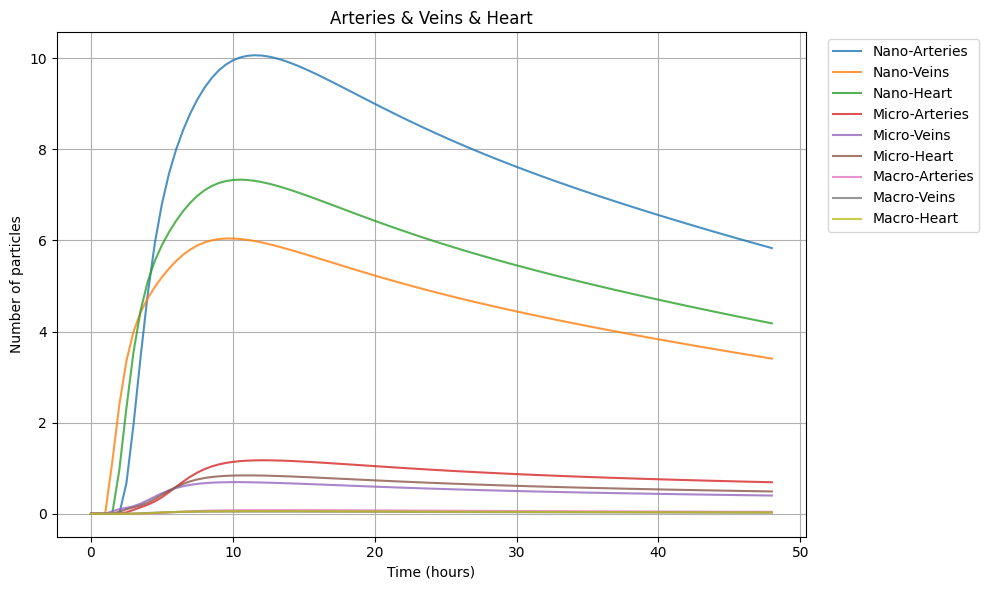

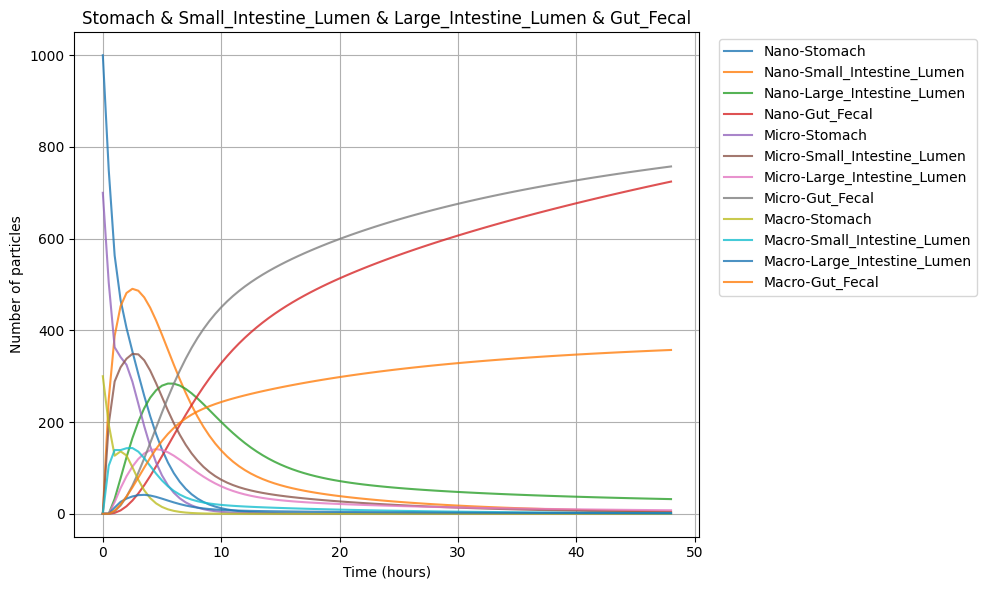

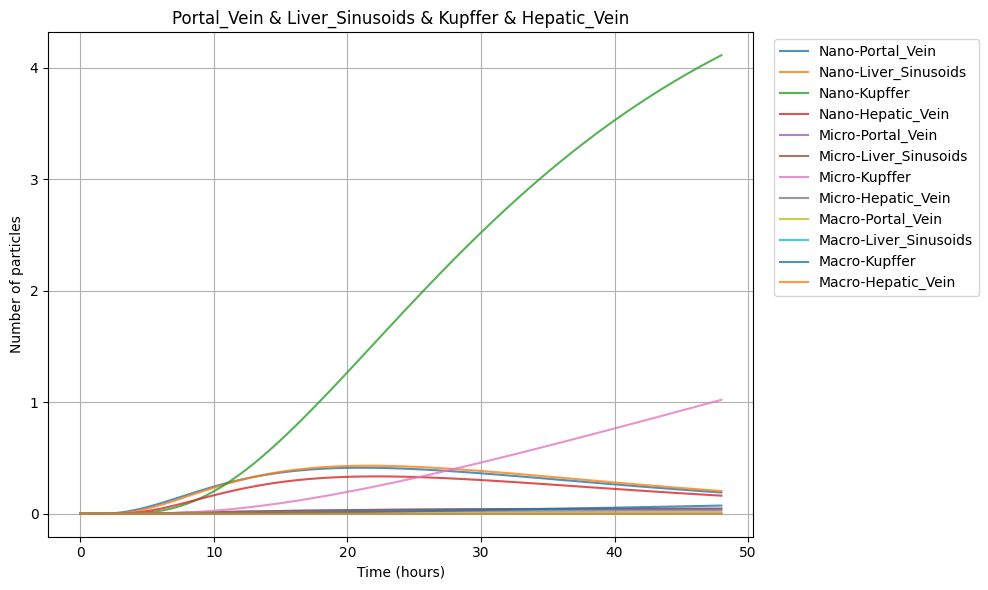

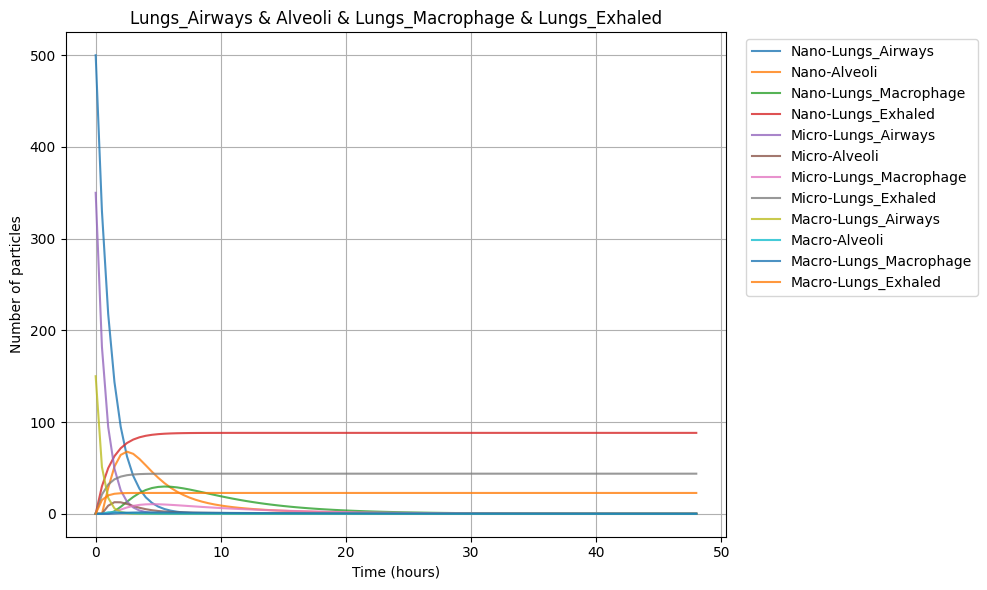

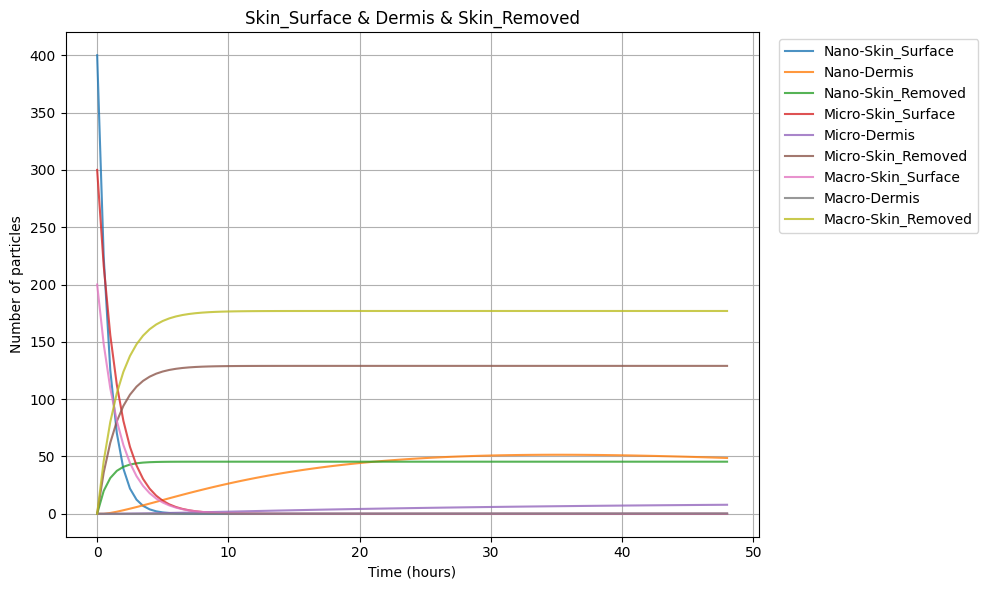

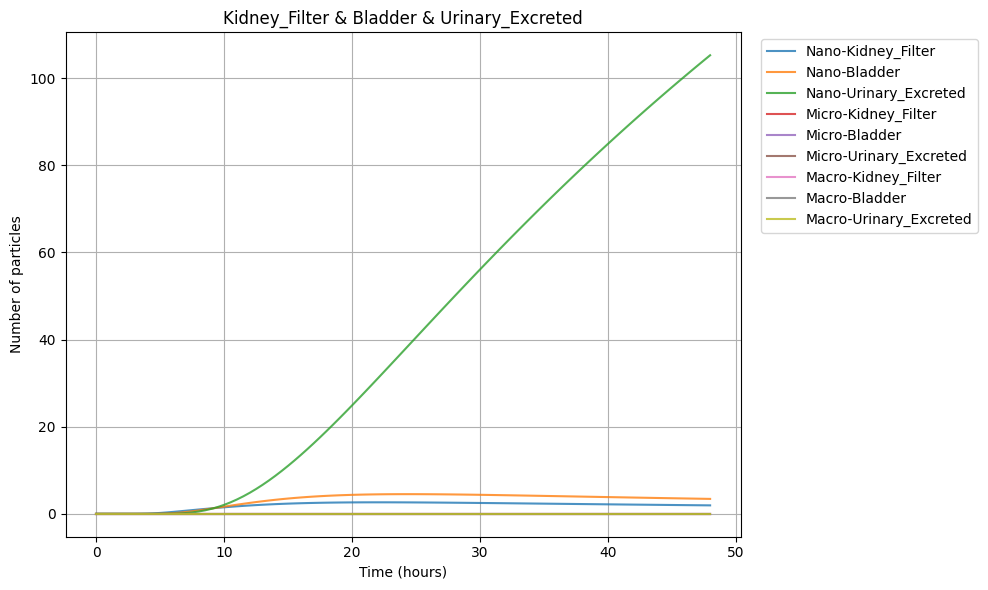

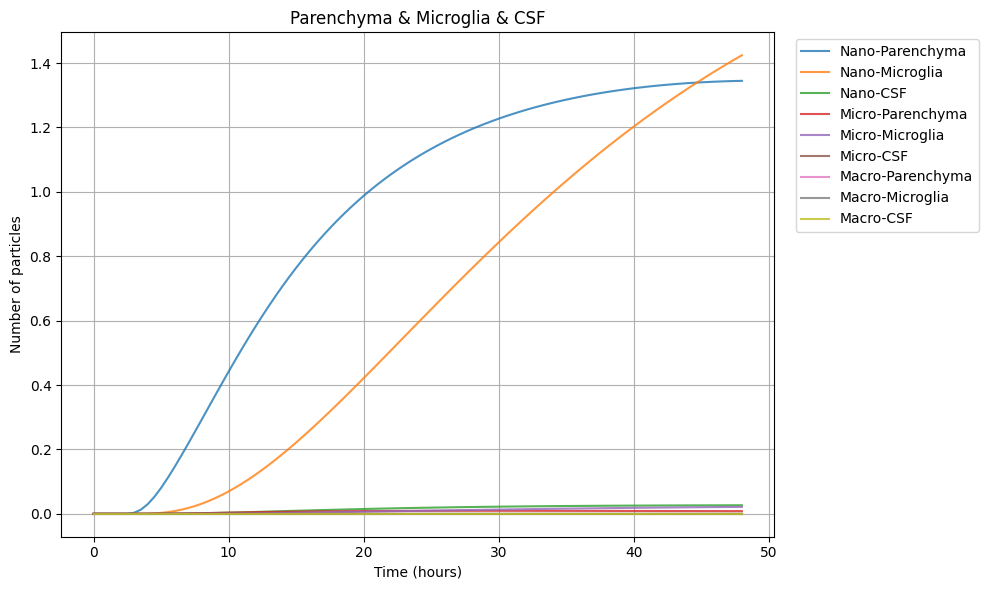

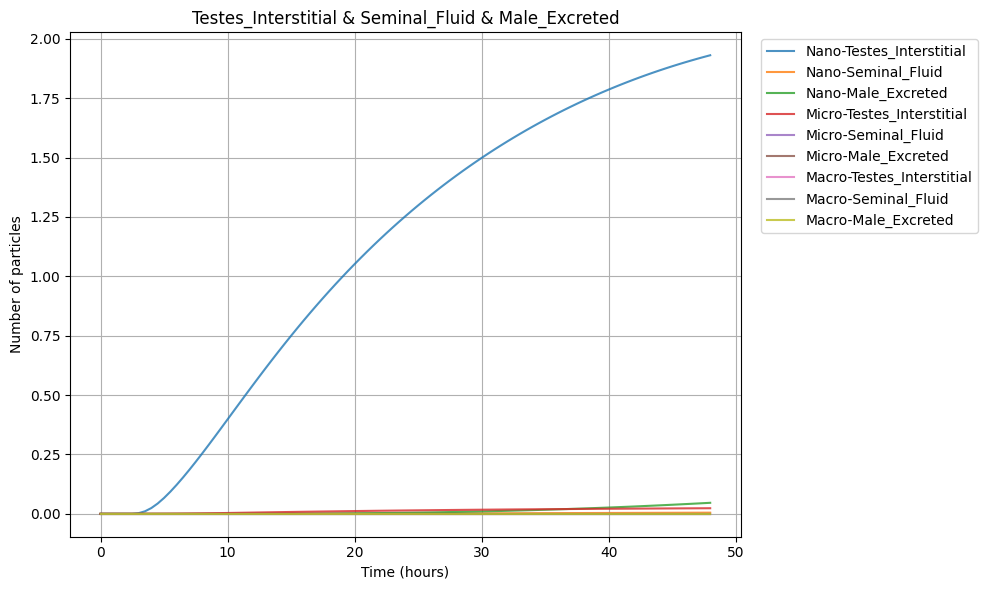

In [ ]:
 # Fully connected Integrated Multi-organ Compartmental Twin (48 h, 0.5 h steps)
# Transfer matrix and dictionaries are strictly literature based

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from copy import deepcopy

# ---------------------------
# Simulation configuration
# ---------------------------
DT_HOURS = 0.5
TOTAL_HOURS = 48
TIMES = np.arange(0, TOTAL_HOURS + DT_HOURS, DT_HOURS)
STEPS = len(TIMES)

MP_CLASSES = ["Nano", "Micro", "Macro"]
SIZE_RANGES = {
    "Nano": "<1 µm (true nanoplastics)",
    "Micro": "1–100 µm",
    "Macro": "100 µm – 1–4 mm"
}

# ---------------------------
# Exposure scenario (initial inputs)
# ---------------------------
EXPOSURE = {
    "oral_total":    {"Nano": 1000.0, "Micro": 700.0, "Macro": 300.0},
    "inhalation_total": {"Nano": 500.0, "Micro": 350.0, "Macro": 150.0},
    "dermal_total":  {"Nano": 400.0, "Micro": 300.0, "Macro": 200.0}
}
TOTAL_INPUT = {cls: sum(EXPOSURE[route].get(cls, 0.0) for route in EXPOSURE) for cls in MP_CLASSES}

# ---------------------------
# Compartments (flat list used throughout printing)
# ---------------------------
CARDIO = ["Arteries", "Veins", "Heart", "Cardiac_Tissue", "Systemic_Tissue"]
GUT = ["Stomach", "Small_Intestine_Lumen", "Small_Intestine_Mucus", "Small_Intestine_Epithelium",
       "Large_Intestine_Lumen", "Large_Intestine_Mucus", "Large_Intestine_Epithelium", "Gut_Fecal", "Portal_Vein"]
LUNGS = ["Lungs_Airways", "Bronchi", "Alveoli", "Lungs_Macrophage", "Lungs_Tissue", "Lungs_Lymph", "Lungs_Cleared_to_Gut", "Lungs_Exhaled"]
SKIN = ["Skin_Surface", "Skin_Follicles", "Stratum_Corneum", "Dermis", "Passed_to_Gut_from_Skin", "Skin_Removed", "Skin_Hands"]
LIVER = ["Liver_Sinusoids", "Kupffer", "Hepatocytes", "Liver_Tissue", "Bile", "Bile_Excreted", "Hepatic_Vein"]
KIDNEY = ["Kidney_Arteries", "Kidney_Filter", "Kidney_Tissue", "Urine_Tube", "Bladder", "Urinary_Excreted"]
NERV = ["Nasal_Mucus", "Olfactory_Epithelium", "Olfactory_Bulb", "CSF", "Parenchyma", "Microglia", "Nervous_Passed_to_Gut", "Nervous_Cleared"]
MALE = ["Testes_Interstitial", "Epididymis", "Seminal_Fluid", "Male_Lymph", "Male_Accumulated", "Male_Excreted"]
LYMPH = ["Interstitial_Fluid", "Lymph_Vessels", "Lymph_Node_Store", "Thoracic_Duct", "Lymph_Removed"]

ALL_COMPS = sorted(set(CARDIO + GUT + LUNGS + SKIN + LIVER + KIDNEY + NERV + MALE + LYMPH))

# ---------------------------
# Full rate dictionaries (The scientific basis for our dynamic matrices)
# ---------------------------
RESPIRATORY_RATES = {
    "Nano": {"air_to_bronchi": 0.28, "bronchi_to_alveoli": 0.20, "bronchi_to_clear": 0.38, "exhaled_from_air": 0.06, "alveoli_to_macrophage": 0.10, "alveoli_to_tissue": 0.10, "alveoli_to_blood": 0.04, "macrophage_to_alveoli": 0.06, "macrophage_to_lymph": 0.06, "tissue_to_blood": 0.05},
    "Micro": {"air_to_bronchi": 0.42, "bronchi_to_alveoli": 0.06, "bronchi_to_clear": 0.68, "exhaled_from_air": 0.06, "alveoli_to_macrophage": 0.22, "alveoli_to_tissue": 0.12, "alveoli_to_blood": 0.006, "macrophage_to_alveoli": 0.04, "macrophage_to_lymph": 0.05, "tissue_to_blood": 0.015},
    "Macro": {"air_to_bronchi": 0.56, "bronchi_to_alveoli": 0.02, "bronchi_to_clear": 0.80, "exhaled_from_air": 0.10, "alveoli_to_macrophage": 0.26, "alveoli_to_tissue": 0.18, "alveoli_to_blood": 0.0001, "macrophage_to_alveoli": 0.02, "macrophage_to_lymph": 0.03, "tissue_to_blood": 0.002}
}
DIGESTIVE_RATES = {
    "Nano": {"gastric_empty": 0.25, "mucus_trap_sm": 0.06, "absorb_epith_sm": 0.025, "enter_blood_sm": 0.010, "to_portal_sm": 0.02, "lumen_to_fecal_lg": 0.07, "lumen_to_fecal_sm": 0.008},
    "Micro": {"gastric_empty": 0.28, "mucus_trap_sm": 0.09, "absorb_epith_sm": 0.002, "enter_blood_sm": 0.0005, "to_portal_sm": 0.001, "lumen_to_fecal_lg": 0.18, "lumen_to_fecal_sm": 0.028},
    "Macro": {"gastric_empty": 0.35, "mucus_trap_sm": 0.13, "absorb_epith_sm": 0.000, "enter_blood_sm": 0.0000, "to_portal_sm": 0.0001, "lumen_to_fecal_lg": 0.32, "lumen_to_fecal_sm": 0.065}
}
EXCRETORY_RATES = {
    "Nano": {"blood_to_filter": 0.08, "filter_to_urine": 0.60, "filter_to_tissue": 0.02, "tissue_to_blood": 0.05, "urine_to_bladder": 0.75, "bladder_to_excrete": 0.35},
    "Micro": {"blood_to_filter": 0.00, "filter_to_urine": 0.00, "filter_to_tissue": 0.00, "tissue_to_blood": 0.005, "urine_to_bladder": 0.75, "bladder_to_excrete": 0.35},
    "Macro": {"blood_to_filter": 0.00, "filter_to_urine": 0.00, "filter_to_tissue": 0.00, "tissue_to_blood": 0.001, "urine_to_bladder": 0.75, "bladder_to_excrete": 0.35}
}
LIVER_RATES = {
    "Nano": {"portal_to_sinus": 0.95, "sinus_to_kupffer": 0.15, "sinus_to_hepatocyte": 0.06, "sinus_passthrough": 0.70, "hepatocyte_to_bile": 0.05, "bile_to_excreted": 0.70},
    "Micro": {"portal_to_sinus": 0.95, "sinus_to_kupffer": 0.35, "sinus_to_hepatocyte": 0.01, "sinus_passthrough": 0.55, "hepatocyte_to_bile": 0.01, "bile_to_excreted": 0.50},
    "Macro": {"portal_to_sinus": 0.95, "sinus_to_kupffer": 0.50, "sinus_to_hepatocyte": 0.001, "sinus_passthrough": 0.45, "hepatocyte_to_bile": 0.001, "bile_to_excreted": 0.20}
}
SKIN_TRANSITIONS = {
    "Nano": {"surface_to_follicle": 0.28, "surface_to_corneum": 0.09, "surface_to_gut": 0.02, "surface_to_removed": 0.05, "corneum_to_dermis": 0.02, "dermis_to_blood": 0.01},
    "Micro": {"surface_to_follicle": 0.14, "surface_to_corneum": 0.01, "surface_to_gut": 0.009, "surface_to_removed": 0.12, "corneum_to_dermis": 0.009, "dermis_to_blood": 0.00},
    "Macro": {"surface_to_follicle": 0.03, "surface_to_corneum": 0.00, "surface_to_gut": 0.000, "surface_to_removed": 0.23, "corneum_to_dermis": 0.000, "dermis_to_blood": 0.0}
}
NERVOUS_RATES = {
    "Nano": {"nasal_to_epithelium": 0.12, "epith_to_olfactory_bulb": 0.03, "epith_to_csf": 0.01, "olf_to_par": 0.02, "nasal_swallow": 0.55, "parenchyma_to_microglia": 0.03, "microglia_release": 0.01, "blood_to_parenchyma": 0.005, "parenchyma_to_csf": 0.002, "csf_clear_swallow": 0.10},
    "Micro": {"nasal_to_epithelium": 0.08, "epith_to_olfactory_bulb": 0.005, "epith_to_csf": 0.001, "olf_to_par": 0.01, "nasal_swallow": 0.60, "parenchyma_to_microglia": 0.05, "microglia_release": 0.002, "blood_to_parenchyma": 0.0005, "parenchyma_to_csf": 0.0008, "csf_clear_swallow": 0.08},
    "Macro": {"nasal_to_epithelium": 0.03, "epith_to_olfactory_bulb": 0.0001, "epith_to_csf": 0.0, "olf_to_par": 0.005, "nasal_swallow": 0.75, "parenchyma_to_microglia": 0.02, "microglia_release": 0.0002, "blood_to_parenchyma": 0.0, "parenchyma_to_csf": 0.0, "csf_clear_swallow": 0.05}
}
MALE_REPRO_RATES = {
    "Nano": {"blood_to_testes": 0.004, "testes_to_epidid": 0.003, "testes_to_accum": 0.004, "testes_detach_to_blood": 0.0015, "epidid_to_seminal": 0.006, "epidid_detach_to_blood": 0.001, "seminal_to_excreted": 0.30},
    "Micro": {"blood_to_testes": 0.0004, "testes_to_epidid": 0.0003, "testes_to_accum": 0.006, "testes_detach_to_blood": 0.0004, "epidid_to_seminal": 0.001, "epidid_detach_to_blood": 0.0002, "seminal_to_excreted": 0.25},
    "Macro": {"blood_to_testes": 0.000, "testes_to_epidid": 0.000, "testes_to_accum": 0.015, "testes_detach_to_blood": 0.0001, "epidid_to_seminal": 0.000, "epidid_detach_to_blood": 0.0001, "seminal_to_excreted": 0.10}
}


# ---------------------------
# Function to Build Size-Specific Transfer Matrices
# ---------------------------
def build_transfer_matrix(cls):
    """
    Builds a complete, size-specific transfer matrix for a given particle class (cls)
    by using the detailed rate dictionaries. This function now integrates ALL organ systems.
    """
    matrix = {}

    # --- Apply size-specific rates from dictionaries ---
    rr = RESPIRATORY_RATES[cls]
    dr = DIGESTIVE_RATES[cls]
    er = EXCRETORY_RATES[cls]
    lr = LIVER_RATES[cls]
    sr = SKIN_TRANSITIONS[cls]
    nr = NERVOUS_RATES[cls]
    mr = MALE_REPRO_RATES[cls]

    # --- Base Physiology (largely size-independent) ---
    matrix["Veins"] = {"Heart": 0.85}
    matrix["Heart"] = {"Arteries": 0.70}
    matrix["Systemic_Tissue"] = {"Veins": 0.04}
    matrix["Lymph_Vessels"] = {"Lymph_Node_Store": 0.20, "Thoracic_Duct": 0.30}
    matrix["Lymph_Node_Store"] = {"Thoracic_Duct": 0.10, "Lymph_Removed": 0.005}
    matrix["Thoracic_Duct"] = {"Veins": 0.70}
    matrix["Lungs_Cleared_to_Gut"] = {"Stomach": 0.8}
    matrix["Passed_to_Gut_from_Skin"] = {"Stomach": 0.10}

    # --- Digestive System ---
    matrix["Stomach"] = {"Small_Intestine_Lumen": dr["gastric_empty"]}
    matrix["Small_Intestine_Lumen"] = {"Large_Intestine_Lumen": 0.13, "Small_Intestine_Mucus": dr["mucus_trap_sm"], "Gut_Fecal": dr["lumen_to_fecal_sm"]}
    matrix["Small_Intestine_Mucus"] = {"Small_Intestine_Epithelium": 0.005, "Small_Intestine_Lumen": 0.05}
    matrix["Small_Intestine_Epithelium"] = {"Blood": dr["enter_blood_sm"], "Portal_Vein": dr["to_portal_sm"]}
    matrix["Large_Intestine_Lumen"] = {"Large_Intestine_Mucus": 0.10, "Gut_Fecal": dr["lumen_to_fecal_lg"]}
    matrix["Large_Intestine_Mucus"] = {"Large_Intestine_Epithelium": 0.001, "Large_Intestine_Lumen": 0.01}
    matrix["Large_Intestine_Epithelium"] = {"Blood": 0.0001, "Gut_Fecal": 0.05}

    # --- Respiratory System ---
    matrix["Lungs_Airways"] = {"Bronchi": rr["air_to_bronchi"], "Lungs_Exhaled": rr["exhaled_from_air"]}
    matrix["Bronchi"] = {"Alveoli": rr["bronchi_to_alveoli"], "Lungs_Cleared_to_Gut": rr["bronchi_to_clear"]}
    matrix["Alveoli"] = {"Lungs_Macrophage": rr["alveoli_to_macrophage"], "Lungs_Tissue": rr["alveoli_to_tissue"], "Blood": rr["alveoli_to_blood"]}
    matrix["Lungs_Macrophage"] = {"Alveoli": rr["macrophage_to_alveoli"], "Lymph_Vessels": rr["macrophage_to_lymph"]}
    matrix["Lungs_Tissue"] = {"Blood": rr["tissue_to_blood"]}

    # --- Skin System ---
    matrix["Skin_Surface"] = {"Skin_Follicles": sr["surface_to_follicle"], "Stratum_Corneum": sr["surface_to_corneum"], "Passed_to_Gut_from_Skin": sr["surface_to_gut"], "Skin_Removed": sr["surface_to_removed"]}
    matrix["Stratum_Corneum"] = {"Dermis": sr["corneum_to_dermis"]}
    matrix["Dermis"] = {"Blood": sr["dermis_to_blood"], "Lymph_Vessels": 0.005}

    # --- Liver System ---
    matrix["Portal_Vein"] = {"Liver_Sinusoids": lr["portal_to_sinus"]}
    matrix["Liver_Sinusoids"] = {"Kupffer": lr["sinus_to_kupffer"], "Hepatocytes": lr["sinus_to_hepatocyte"], "Hepatic_Vein": lr["sinus_passthrough"]}
    matrix["Hepatocytes"] = {"Bile": lr["hepatocyte_to_bile"]}
    matrix["Bile"] = {"Large_Intestine_Lumen": 0.40, "Bile_Excreted": lr["bile_to_excreted"]}
    matrix["Hepatic_Vein"] = {"Veins": 0.90}

    # --- Kidney (Excretory) System ---
    matrix["Kidney_Filter"] = {"Urine_Tube": er["filter_to_urine"], "Kidney_Tissue": er["filter_to_tissue"], "Veins": 0.05} # Reabsorption
    matrix["Kidney_Tissue"] = {"Veins": er["tissue_to_blood"]}
    matrix["Urine_Tube"] = {"Bladder": er["urine_to_bladder"]}
    matrix["Bladder"] = {"Urinary_Excreted": er["bladder_to_excrete"]}

    # --- Nervous System (Full) ---
    matrix["Nasal_Mucus"] = {"Olfactory_Epithelium": nr["nasal_to_epithelium"], "Stomach": nr["nasal_swallow"]}
    matrix["Olfactory_Epithelium"] = {"Olfactory_Bulb": nr["epith_to_olfactory_bulb"], "CSF": nr["epith_to_csf"]}
    matrix["Olfactory_Bulb"] = {"Parenchyma": nr["olf_to_par"]}
    matrix["Parenchyma"] = {"Microglia": nr["parenchyma_to_microglia"], "CSF": nr["parenchyma_to_csf"]}
    matrix["Microglia"] = {"Parenchyma": nr["microglia_release"], "Nervous_Cleared": 0.01} # Generic clearance
    matrix["CSF"] = {"Stomach": nr["csf_clear_swallow"]}

    # --- Male Reproductive System (Full) ---
    matrix["Testes_Interstitial"] = {"Epididymis": mr["testes_to_epidid"], "Male_Accumulated": mr["testes_to_accum"], "Veins": mr["testes_detach_to_blood"]}
    matrix["Epididymis"] = {"Seminal_Fluid": mr["epidid_to_seminal"], "Veins": mr["epidid_detach_to_blood"]}
    matrix["Seminal_Fluid"] = {"Male_Excreted": mr["seminal_to_excreted"]}

    # --- Arterial Distribution (Central Hub) ---
    matrix["Arteries"] = {
        "Systemic_Tissue": 0.25,
        "Kidney_Arteries": 0.20,
        "Dermis": 0.05,
        "Parenchyma": nr["blood_to_parenchyma"],
        "Testes_Interstitial": mr["blood_to_testes"]
    }
    matrix["Kidney_Arteries"] = {"Kidney_Filter": er["blood_to_filter"]}


    # --- Finalization: Ensure all compartments exist and are connected ---
    for c in ALL_COMPS:
        if c not in matrix:
            matrix[c] = {}

    tiny_connect = 1e-5
    exits = set(["Gut_Fecal", "Urinary_Excreted", "Bile_Excreted", "Lungs_Exhaled", "Skin_Removed", "Male_Excreted", "Lymph_Removed", "Nervous_Cleared"])
    for comp in matrix:
        if comp not in exits and not matrix[comp]:
            matrix[comp]["Veins"] = tiny_connect
            matrix[comp]["Lymph_Vessels"] = tiny_connect

    return matrix

# ---------------------------
# Create all size-specific transfer matrices
# ---------------------------
transfer_matrices = {cls: build_transfer_matrix(cls) for cls in MP_CLASSES}
print("Successfully built fully integrated, size-specific transfer matrices.")

# ---------------------------
# Initialize state arrays
# ---------------------------
state0 = {cls: {c: 0.0 for c in ALL_COMPS} for cls in MP_CLASSES}
for cls in MP_CLASSES:
    state0[cls]["Stomach"] = EXPOSURE["oral_total"].get(cls, 0.0)
    state0[cls]["Lungs_Airways"] = EXPOSURE["inhalation_total"].get(cls, 0.0)
    state0[cls]["Skin_Surface"] = EXPOSURE["dermal_total"].get(cls, 0.0)

history = {cls: [deepcopy(state0[cls])] for cls in MP_CLASSES}

# ---------------------------
# Simulation loop using the DYNAMIC, size-specific transfer matrices
# ---------------------------
for step in range(1, STEPS):
    for cls in MP_CLASSES:
        current_transfer_matrix = transfer_matrices[cls]

        prev = history[cls][-1]
        next_row = deepcopy(prev)

        for src, destinations in current_transfer_matrix.items():
            amt_to_move = prev.get(src, 0.0)
            if amt_to_move <= 0 or not destinations:
                continue

            total_frac = sum(destinations.values())
            scale = 1.0 if total_frac <= 1.0 else 1.0 / total_frac

            outflow_total = 0
            for dst, frac in destinations.items():
                moved = amt_to_move * frac * scale
                if dst in ALL_COMPS:
                    next_row[dst] += moved
                outflow_total += moved

            next_row[src] -= outflow_total

        # --- Mass Conservation and Finalization ---
        total_next = sum(next_row.values())
        expected = TOTAL_INPUT[cls]
        diff = expected - total_next
        if abs(diff) > 1e-9:
            next_row["Veins"] += diff

        for c in ALL_COMPS:
            next_row[c] = max(0.0, next_row.get(c, 0.0))

        history[cls].append(next_row)

print("Simulation loop completed.")

# ---------------------------
# Convert history to DataFrames and save CSVs
# ---------------------------
out_dir = "/content"
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

dfs = {}
for cls in MP_CLASSES:
    dfs[cls] = pd.DataFrame(history[cls], index=TIMES)
    file_path = os.path.join(out_dir, f"integrated_twin_timeseries_{cls}.csv")
    dfs[cls].to_csv(file_path)
print("Wrote time-series CSV files.")

final_df = pd.DataFrame({cls: dfs[cls].iloc[-1] for cls in MP_CLASSES}).T
final_df["Initial_total_input"] = [TOTAL_INPUT[cls] for cls in MP_CLASSES]
cols = ["Initial_total_input"] + [c for c in ALL_COMPS if c in final_df.columns]
final_df = final_df[cols]
final_file = os.path.join(out_dir, "integrated_twin_results.csv")
final_df.to_csv(final_file)
print("Wrote integrated_twin_results.csv.")

# ---------------------------
# Plotting
# ---------------------------
plot_groups = [
    ["Arteries", "Veins", "Heart"], ["Stomach", "Small_Intestine_Lumen", "Large_Intestine_Lumen", "Gut_Fecal"],
    ["Portal_Vein", "Liver_Sinusoids", "Kupffer", "Hepatic_Vein"], ["Lungs_Airways", "Alveoli", "Lungs_Macrophage", "Lungs_Exhaled"],
    ["Skin_Surface", "Dermis", "Skin_Removed"], ["Kidney_Filter", "Bladder", "Urinary_Excreted"],
    ["Parenchyma", "Microglia", "CSF"], ["Testes_Interstitial", "Seminal_Fluid", "Male_Excreted"]
]
for group in plot_groups:
    plt.figure(figsize=(10, 6))
    for cls, color in zip(MP_CLASSES, ["tab:blue", "tab:green", "tab:red"]):
        for comp in group:
            if comp in dfs[cls].columns:
                plt.plot(dfs[cls].index, dfs[cls][comp], label=f"{cls}-{comp}", alpha=0.8)
    plt.title(" & ".join(group))
    plt.xlabel("Time (hours)")
    plt.ylabel("Number of particles")
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.grid(True); plt.tight_layout()
    # plt.show()
print("[Plot generation step completed]")

# ---------------------------
# Final numeric summary
# ---------------------------
PRINTING_ORDER = [
    "Blood", "Lymph", "Stomach", "Small_Intestine_Lumen", "Small_Intestine_Epithelium", "Large_Intestine_Lumen", "Gut_Fecal",
    "Lungs_Airways", "Alveoli", "Lungs_Macrophage", "Lungs_Exhaled", "Skin_Surface", "Dermis", "Skin_Removed",
    "Portal_Vein", "Liver_Sinusoids", "Kupffer", "Hepatocytes", "Bile_Excreted",
    "Kidney_Filter", "Bladder", "Urinary_Excreted",
    "Parenchyma", "Microglia", "CSF", "Nervous_Cleared",
    "Testes_Interstitial", "Epididymis", "Seminal_Fluid", "Male_Accumulated", "Male_Excreted", "Lymph_Node_Store"
]
print("\n--- FINAL NUMERIC SUMMARY (Fully Integrated Dynamic Rates) ---")
for cls in MP_CLASSES:
    final = dfs[cls].iloc[-1]
    initial = float(TOTAL_INPUT[cls])
    print_vals = {comp: float(final.get(comp, 0.0)) for comp in ALL_COMPS}
    blood_val = (final.get("Arteries", 0.0) + final.get("Veins", 0.0) + final.get("Heart", 0.0))
    lymph_val = (final.get("Lymph_Vessels", 0.0) + final.get("Lymph_Node_Store", 0.0) + final.get("Thoracic_Duct", 0.0))
    print_vals["Blood"] = float(blood_val)
    print_vals["Lymph"] = float(lymph_val)

    print(f"\n{cls} Particles (Initial: {int(initial)}, {SIZE_RANGES[cls]}):")
    for comp in PRINTING_ORDER:
        if comp in print_vals:
            val = float(print_vals.get(comp, 0.0))
            pct = (val / initial * 100.0) if initial > 0 else 0.0
            print(f"  {comp:28s}: {val:10.2f} ({pct:6.2f}%)")
    total = final.sum()
    print(f"  {'Total check':28s}: {total:10.2f} / {initial:.0f} ({(total/initial*100.0 if initial>0 else 0.0):.2f}%)")

print("\nSimulation complete.")